In [6]:
import torch
import gpytorch
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import gc

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [12]:
from scripts.utils import train_keys, target_keys, ScaleData

In [13]:
target_keys

['dfeitg_gb_div_efiitg_gb',
 'dfetem_gb_div_efetem_gb',
 'dfiitg_gb_div_efiitg_gb',
 'dfitem_gb_div_efetem_gb',
 'efeetg_gb',
 'efeitg_gb_div_efiitg_gb',
 'efetem_gb',
 'efiitg_gb',
 'efitem_gb_div_efetem_gb',
 'pfeitg_gb_div_efiitg_gb',
 'pfetem_gb_div_efetem_gb',
 'pfiitg_gb_div_efiitg_gb',
 'pfitem_gb_div_efetem_gb',
 'vceitg_gb_div_efiitg_gb',
 'vcetem_gb_div_efetem_gb',
 'vciitg_gb_div_efiitg_gb',
 'vcitem_gb_div_efetem_gb',
 'vfiitg_gb_div_efiitg_gb',
 'vfitem_gb_div_efetem_gb',
 'vriitg_gb_div_efiitg_gb',
 'vritem_gb_div_efetem_gb',
 'vteitg_gb_div_efiitg_gb',
 'vtiitg_gb_div_efiitg_gb']

In [34]:
train_data_path = "../../data/train_data_clipped.pkl"
df_train = pd.read_pickle(train_data_path)

In [65]:
used = train_keys + ['efeitg_gb_div_efiitg_gb']

training_data = df_train[used].dropna().sample(100_000)
training_data, scaler = ScaleData(training_data)

X_train = training_data[train_keys]
y_train = training_data['efeitg_gb_div_efiitg_gb']

X_train = torch.tensor(X_train.values, dtype = torch.float)
y_train = torch.tensor(y_train.values, dtype = torch.float)

In [67]:
data_dim = 15

class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(data_dim, 100))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(100, 50))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(50, 10))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(10, 2))

feature_extractor = LargeFeatureExtractor()

In [68]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
                num_dims=2, grid_size=100
            )
            self.feature_extractor = feature_extractor

            # This module will scale the NN features so that they're nice values
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            projected_x = self.feature_extractor(x)
            projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [69]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(X_train, y_train, likelihood)

In [82]:
training_iterations = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train():
    iterator = tqdm.notebook.tqdm(range(training_iterations))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(X_train)
        # Calc loss and backprop derivatives
        loss = -mll(output, y_train)
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()

%time train()



  0%|          | 0/50 [00:00<?, ?it/s]

/home/jbarr/.conda/envs/UKAEA/lib/python3.9/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.7826359272003174 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/jbarr/.conda/envs/UKAEA/lib/python3.9/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.8652383089065552 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/jbarr/.conda/envs/UKAEA/lib/python3.9/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG 

CPU times: user 22min 37s, sys: 28.5 s, total: 23min 6s
Wall time: 23min 10s


In [36]:
test_data_path = "../../data/valid_data_clipped.pkl"
df_test = pd.read_pickle(test_data_path)

used = train_keys + ['efeitg_gb_div_efiitg_gb']

test_data = df_test[used].dropna().sample(10_000)
test_data, scaler = ScaleData(training_data, scaler)

X_test = test_data[train_keys]
y_test = test_data['efeitg_gb_div_efiitg_gb']

X_test = torch.tensor(X_test.values, dtype = torch.float)
y_test = torch.tensor(y_test.values, dtype = torch.float)

In [83]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(X_test)


/home/jbarr/.conda/envs/UKAEA/lib/python3.9/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.039956722408533096 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


In [84]:
print('Test MAE: {}'.format(torch.mean(torch.abs(preds.mean - y_test))))

Test MAE: 3.40828013420105


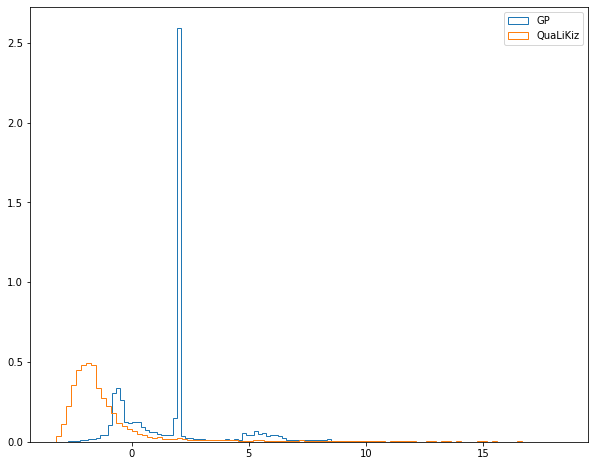

In [85]:
plt.figure(figsize = (10,8))
plt.hist(preds.mean.detach().numpy(), bins = 100, histtype = 'step', label = "GP", density = True);
plt.hist(y_test.detach().numpy(), bins = 100, histtype = 'step', label = "QuaLiKiz", density = True);
plt.legend()